Driven Cavity Simulation: Re=1000
Solver Grid: 41x41, Time step: 0.0005, Final Time: 5.1
Setting up simulation grid and weights...
Starting time-stepping loop...
  ... Stored particle state at t=1.0
  ... Stored particle state at t=5.0
Simulation finished.


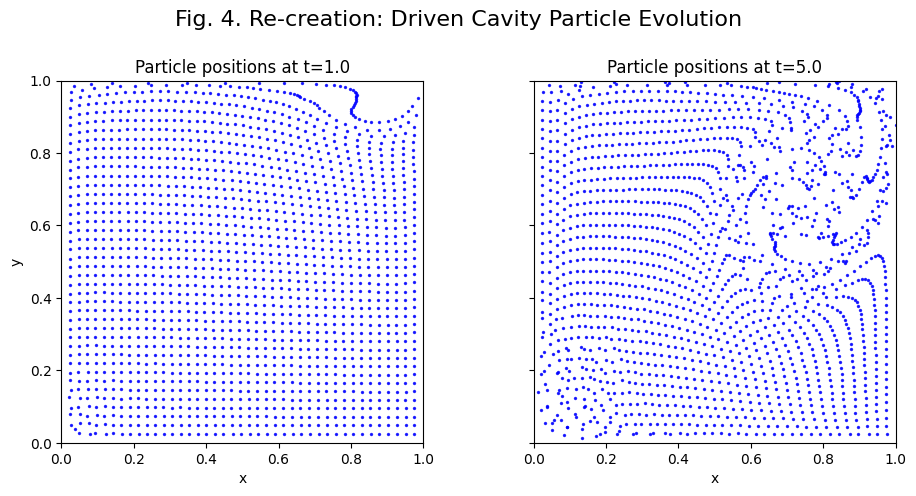

In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

L = 1.0  
K = 1.0 
nu = 0.001 
rho = 1.0  

Nx, Ny = 41, 41
N = Nx * Ny
stencil_size = 9 # Number of neighbors for GFDM

# Time-stepping parameters
dx = K / (Nx - 1)
dy = L / (Ny - 1) 
dt = 0.0005
t_final = 5.1 
times_to_plot = [1.0, 5.0]

print(f"Driven Cavity Simulation: Re=1000")
print(f"Solver Grid: {Nx}x{Ny}, Time step: {dt}, Final Time: {t_final:.1f}")

# ----------(GFDM part is reusable) ---------
def generate_2d_nodes(K, L, Nx, Ny):
    """Generates a regular 2D grid and identifies boundary nodes."""
    x_1d, y_1d = cp.linspace(0, K, Nx), cp.linspace(0, L, Ny)
    x, y = cp.meshgrid(x_1d, y_1d)
    x, y = x.flatten(), y.flatten()
    
    # Identify boundary nodes based on their coordinates
    bottom_nodes = cp.where(cp.isclose(y, 0))[0]
    top_nodes = cp.where(cp.isclose(y, L))[0]
    left_nodes = cp.where(cp.isclose(x, 0))[0]
    right_nodes = cp.where(cp.isclose(x, K))[0]
    
    boundary_nodes = cp.unique(cp.concatenate([bottom_nodes, top_nodes, left_nodes, right_nodes]))
    interior_nodes = cp.setdiff1d(cp.arange(N), boundary_nodes, assume_unique=True)
    
    return x, y, bottom_nodes, top_nodes, left_nodes, right_nodes, interior_nodes

def compute_full_2d_gfdm_weights(x, y, stencil_size, epsilon=1e-8):
    """Computes GFDM weights for d/dx, d/dy, and Laplacian on a point cloud."""
    N = len(x)
    w_dx, w_dy, w_lap = [cp.zeros((N, stencil_size)) for _ in range(3)]
    stencil_indices = cp.zeros((N, stencil_size), dtype=cp.int32)
    # Taylor expansion vectors for [f, df/dx, df/dy, d2f/dx2, d2f/dxdy, d2f/dy2]
    b_dx = cp.array([0.,1.,0.,0.,0.,0.])
    b_dy = cp.array([0.,0.,1.,0.,0.,0.])
    b_lap = cp.array([0.,0.,0.,2*0.5,0.,2*0.5]) # d2/dx2 + d2/dy2

    for i in range(N):
        distances = cp.sqrt((x - x[i])**2 + (y - y[i])**2)
        indices = cp.argsort(distances)[:stencil_size]
        stencil_indices[i] = indices
        
        dx_s, dy_s = x[indices] - x[i], y[indices] - y[i]
        
        # Power matrix for Taylor expansion
        P = cp.vstack([cp.ones(stencil_size), dx_s, dy_s, 0.5*dx_s**2, dx_s*dy_s, 0.5*dy_s**2]).T
        
        # Weighted least squares
        avg_dist = cp.mean(distances[indices][1:])
        W_diag = cp.exp(-(distances[indices]/(avg_dist+1e-9))**2)
        M_inv = cp.linalg.inv(P.T @ cp.diag(W_diag) @ P + epsilon*cp.eye(6))
        R = M_inv @ P.T @ cp.diag(W_diag)
        
        w_dx[i,:], w_dy[i,:], w_lap[i,:] = b_dx @ R, b_dy @ R, b_lap @ R
        
    return w_dx, w_dy, w_lap, stencil_indices

# --- 3. Main Simulation ---
print("Setting up simulation grid and weights...")
# Generate solver grid and identify boundary regions
x, y, bottom_nodes, top_nodes, left_nodes, right_nodes, interior_nodes = generate_2d_nodes(K, L, Nx, Ny)
stationary_wall_nodes = cp.unique(cp.concatenate([bottom_nodes, left_nodes, right_nodes]))

# Compute the GFDM differentiation weights (one-time cost)
w_dx, w_dy, w_lap, s_idx = compute_full_2d_gfdm_weights(x, y, stencil_size)

# Initialize velocity (u, v) and pressure (p) fields
u, v, p = cp.zeros(N), cp.zeros(N), cp.zeros(N)

# Apply the specific driven cavity boundary conditions
u[stationary_wall_nodes] = 0.0
v[stationary_wall_nodes] = 0.0
# Moving top lid with parabolic velocity profile
x_top = x[top_nodes]
u[top_nodes] = 16 * x_top**2 * (1 - x_top)**2
v[top_nodes] = 0.0

# --- Setup for Particle Advection Visualization ---
# Use a finer grid for tracer particles to get a dense plot
N_tracer = 41
tracer_x, tracer_y = cp.meshgrid(
    cp.linspace(dx, K - dx, N_tracer), 
    cp.linspace(dy, L - dy, N_tracer)
)
tracer_x, tracer_y = tracer_x.flatten(), tracer_y.flatten()
particle_history = {}
steps_to_plot = [int(round(t / dt)) for t in times_to_plot]
n_steps = int(round(t_final / dt))

# --- Main Time-Stepping Loop ---
print("Starting time-stepping loop...")
for step in range(1, n_steps + 1):
    u_old, v_old = u.copy(), v.copy()

    # Calculate derivatives using pre-computed weights
    dudx = cp.sum(w_dx * u_old[s_idx], axis=1)
    dudy = cp.sum(w_dy * u_old[s_idx], axis=1)
    dvdx = cp.sum(w_dx * v_old[s_idx], axis=1)
    dvdy = cp.sum(w_dy * v_old[s_idx], axis=1)
    lap_u = cp.sum(w_lap * u_old[s_idx], axis=1)
    lap_v = cp.sum(w_lap * v_old[s_idx], axis=1)

    # 1. Compute intermediate velocity (u_star) using Chorin's projection method
    # Includes the crucial non-linear convection term: (u_old . grad)u_old
    conv_u = u_old * dudx + v_old * dudy
    conv_v = u_old * dvdx + v_old * dvdy
    u_star = u_old + dt * (-conv_u + nu * lap_u)
    v_star = v_old + dt * (-conv_v + nu * lap_v)

    # Enforce BCs on the intermediate velocity
    u_star[stationary_wall_nodes], v_star[stationary_wall_nodes] = 0.0, 0.0
    u_star[top_nodes] = 16 * x_top**2 * (1 - x_top)**2
    v_star[top_nodes] = 0.0

    # 2. Solve Pressure Poisson Equation: Lap(p) = (rho/dt) * Div(u_star)
    div_u_star = cp.sum(w_dx * u_star[s_idx], axis=1) + cp.sum(w_dy * v_star[s_idx], axis=1)
    b_ppe = (rho / dt) * div_u_star
    
    # Assemble pressure matrix A_ppe (Laplacian for interior, Neumann for boundary)
    A_ppe = cp.zeros((N, N))
    for i in interior_nodes.tolist(): # .tolist() is needed for cupy indexing here
        A_ppe[i, s_idx[i]] = w_lap[i]
    # Enforce Neumann BC (dp/dn=0) on all walls
    for i in cp.union1d(left_nodes, right_nodes).tolist():
        A_ppe[i, s_idx[i]] = w_dx[i]
        b_ppe[i] = 0.0
    for i in cp.union1d(top_nodes, bottom_nodes).tolist():
        A_ppe[i, s_idx[i]] = w_dy[i]
        b_ppe[i] = 0.0

    # Pin one pressure point to ensure a unique solution
    A_ppe[0, :], A_ppe[0, 0], b_ppe[0] = 0.0, 1.0, 0.0
    
    p_new = cp.linalg.solve(A_ppe, b_ppe)

    # 3. Correct the final velocity
    dp_dx = cp.sum(w_dx * p_new[s_idx], axis=1)
    dp_dy = cp.sum(w_dy * p_new[s_idx], axis=1)
    u = u_star - (dt / rho) * dp_dx
    v = v_star - (dt / rho) * dp_dy

    # Re-enforce final velocity BCs
    u[stationary_wall_nodes], v[stationary_wall_nodes] = 0.0, 0.0
    u[top_nodes] = 16 * x_top**2 * (1 - x_top)**2
    v[top_nodes] = 0.0
    
    # --- 4. Advect tracer particles for visualization ---
    # Transfer data to CPU for interpolation with scipy
    if step % 10 == 0: # Advect less frequently to speed up
      u_cpu, v_cpu = u.get(), v.get()
      x_grid_cpu, y_grid_cpu = x.get(), y.get()
      tracer_x_cpu, tracer_y_cpu = tracer_x.get(), tracer_y.get()

      # Interpolate velocity from the solver grid to the particle positions
      points = np.vstack((x_grid_cpu, y_grid_cpu)).T
      u_interp = griddata(points, u_cpu, (tracer_x_cpu, tracer_y_cpu), method='linear', fill_value=0)
      v_interp = griddata(points, v_cpu, (tracer_x_cpu, tracer_y_cpu), method='linear', fill_value=0)
      
      # Update particle positions using a simple forward Euler step
      tracer_x_cpu += u_interp * dt * 10
      tracer_y_cpu += v_interp * dt * 10
      tracer_x, tracer_y = cp.asarray(tracer_x_cpu), cp.asarray(tracer_y_cpu)

    # Store particle positions at specified times
    if step in steps_to_plot:
        t_current = times_to_plot[steps_to_plot.index(step)]
        particle_history[t_current] = (tracer_x.get().copy(), tracer_y.get().copy())
        print(f"  ... Stored particle state at t={t_current:.1f}")

print("Simulation finished.")

# ----------- Plotting---------------
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Plot for t=1.0
t1 = times_to_plot[0]
px1, py1 = particle_history[t1]
axes[0].scatter(px1, py1, s=2, c='blue', alpha=0.8)
axes[0].set_title(f'Particle positions at t={t1:.1f}')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# Plot for t=5.0
t2 = times_to_plot[1]
px2, py2 = particle_history[t2]
axes[1].scatter(px2, py2, s=2, c='blue', alpha=0.8)
axes[1].set_title(f'Particle positions at t={t2:.1f}')
axes[1].set_xlabel('x')
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
fig.suptitle('Fig. 4. Re-creation: Driven Cavity Particle Evolution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()